### TCC Feadback 


In [1]:
import numpy as np
import scipy as sp
import scipy.stats as sp_stats
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import LZH_Utilities as utl

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [2]:
def transpose_stack(arr):
    return np.array([arr]).T

def tsr(arr):
    return torch.tensor(arr)

def plot(x, y, x_label="", y_label="", legend="", title=""):
    plt.figure(figsize=[8, 6], dpi=300)
    
    if (type(legend) is list):
        for yy in y:
            plt.plot(x, yy)
        plt.legend(legend)
    else: 
        plt.plot(x, y)
        
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

In [3]:
def plot_diff_percentage(x, y, x_label="", y_label="", title=""):
    plt.figure(figsize=[8, 6])
    
    x_fit = np.linspace(0, 100, 1000)
    y_fit1 = np.polyval(np.polyfit(x, y, 1), x_fit)
    
    plt.scatter(x, y, s=0.5, c='k')
    plt.plot(x_fit, y_fit1, "r")
        
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(["linear regression", "data"])
    plt.ylim([0, 100])
    plt.xlim([0, 100])
    plt.title(title)
    plt.show()
    
    result = sp_stats.linregress(x, y)
    print("     slope: {0}".format(result.slope))
    print(" intercept: {0}".format(result.intercept))
    print("corr coeff: {0}".format(result.rvalue))
    print("  variance: {0}".format(result.rvalue ** 2))

def plot_diff_percentage_bined_average(x, y, x_label="", y_label="", title="", bin_count=10):
    plt.figure(figsize=[8, 6])
    
    # Overall
    x_fit = np.linspace(0, 100, 10)
    y_fit1 = np.polyval(np.polyfit(x, y, 1), x_fit)
    
    plt.scatter(x, y, s=0.5, alpha=0.3, c='k', label="ERA5 Prediction")
    plt.plot(x_fit, y_fit1, "r", label="Linear Regression")
        
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    result = sp_stats.linregress(x, y)
    print("Overall:")
    print("     slope: {0}".format(result.slope))
    print(" intercept: {0}".format(result.intercept))
    print("corr coeff: {0}".format(result.rvalue))
    print("  variance: {0}".format(result.rvalue ** 2))
    print()
    
    # Binned Average
    is_label_printed = False
    
    bin_arr = np.linspace(0, 100, bin_count+1)
    for (low, high) in zip(bin_arr[:-1], bin_arr[1:]):
        
        bin_filter = np.logical_and(low <= x, x <= high)
        x_bin = x[bin_filter]
        y_bin = y[bin_filter]
        
        if (np.count_nonzero(bin_filter) < 2):
            continue
        
        x_fit = np.linspace(low, high, 10)
        y_fit1 = np.polyval(np.polyfit(x_bin, y_bin, 1), x_fit)
        
        if (not is_label_printed):
            plt.plot(x_fit, y_fit1, "b", label="Binned Linear reg.")
            is_label_printed = True
        else:
            plt.plot(x_fit, y_fit1, "b")
            
        result = sp_stats.linregress(x_bin, y_bin)
        print("[{4:>3}, {5:>3}):   b:{0:.4f};  m:{1:.4f}; r:{2:.4f}; var:{3:.4f}".format(result.slope, result.intercept, result.rvalue, result.rvalue ** 2, int(low), int(high)))
        

            
    plt.legend()
    plt.ylim([0, 100])
    plt.xlim([0, 100])
    plt.title(title)
    plt.show()


In [4]:
df = utl.read_time_series_data("full_rank_dataset_ERA5")

In [5]:
df[0]["TCC_FB"] = 0
for idx in np.arange(8):
    df[idx+1]["TCC_FB"] = df[idx]["TCC"]

In [6]:
# assigning new order
new_col = ['LTS', 'SST', 'Subsidence', 'Night_Day', 'RH', 'q', 'wsp', 'TCC_FB', 'TCC', 'ERA5']

for idx in np.arange(len(df)):
    df[idx] = df[idx][new_col]

In [7]:
idx_test_set = np.random.choice(np.arange(df[0].shape[0]), [int(0.1 * df[0].shape[0])], False)
idx_training_set = np.delete(np.arange(df[0].shape[0]), idx_test_set)

In [8]:
time_arr = np.arange(9)

X_full = [df[time].iloc[:, np.arange(8)].to_numpy() for time in time_arr]
y_hat_full = [np.c_[df[time].iloc[:, -2].to_numpy()] for time in time_arr]
y_ERA5_full = [np.c_[df[time].iloc[:, -1].to_numpy()] for time in time_arr]

X_train = np.array([X_full[time][idx_training_set] for time in time_arr])
y_hat_train = np.array([y_hat_full[time][idx_training_set] for time in time_arr])
y_ERA5_train = np.array([y_ERA5_full[time][idx_training_set] for time in time_arr])

X_test = np.array([X_full[time][idx_test_set] for time in time_arr])
y_hat_test = np.array([y_hat_full[time][idx_test_set] for time in time_arr])
y_ERA5_test = np.array([y_ERA5_full[time][idx_test_set] for time in time_arr])

In [9]:
y_era5 = y_ERA5_test[8, :, 0]
y_true = y_hat_test[8, :, 0]

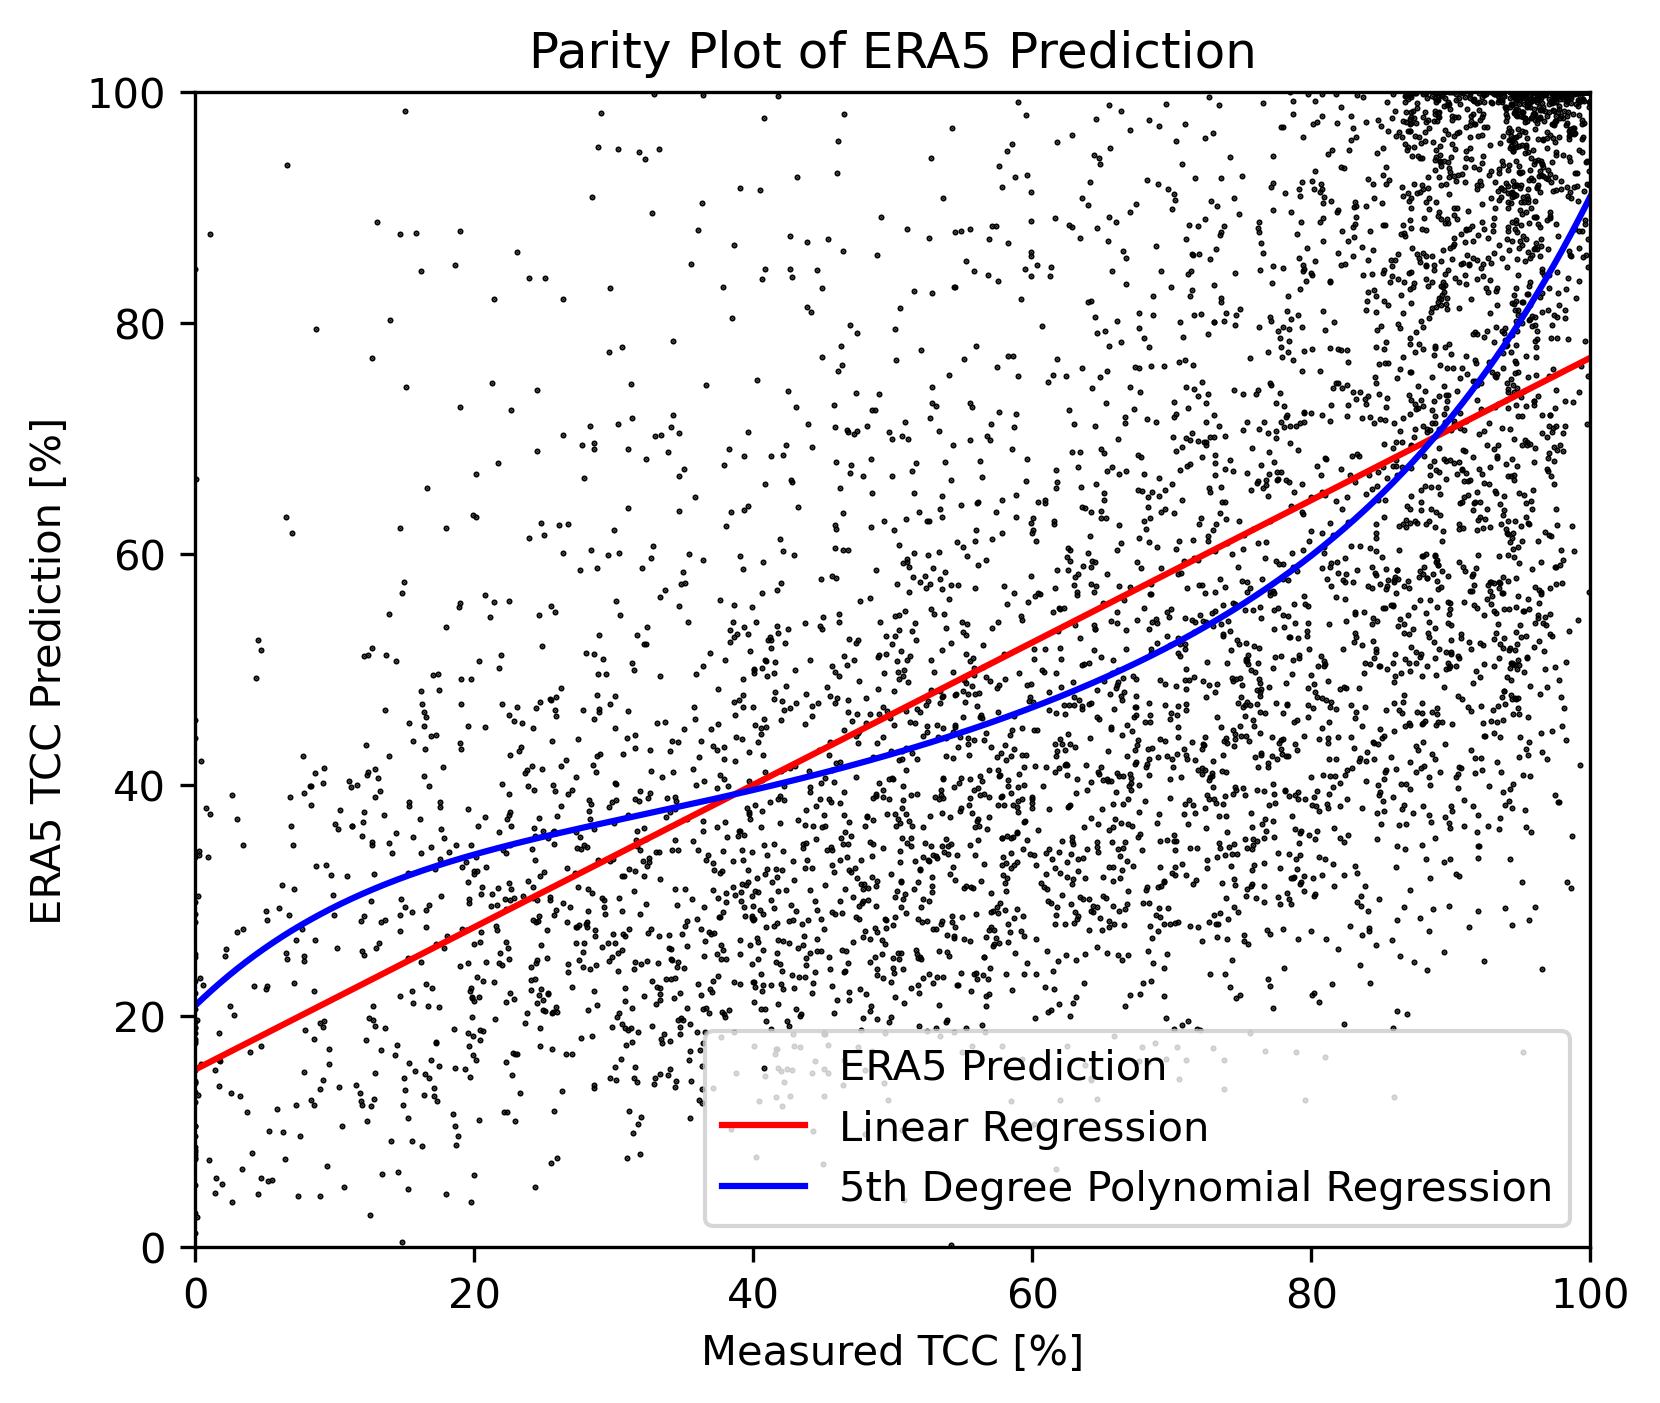

In [10]:
x, y = y_true, y_era5

plt.figure(figsize=[6, 5])

plt.scatter(x, y, s=0.2, c='k', label="ERA5 Prediction")

x_fit = np.linspace(0, 100, 1000)
y_fit1 = np.polyval(np.polyfit(x, y, 1), x_fit)
y_fit2 = np.polyval(np.polyfit(x, y, 5), x_fit)

plt.plot(x_fit, y_fit1, "r", label="Linear Regression")
plt.plot(x_fit, y_fit2, "b", label="5th Degree Polynomial Regression")

plt.ylim([0, 100])
plt.xlim([0, 100])

plt.xlabel("Measured TCC [%]")
plt.ylabel("ERA5 TCC Prediction [%]")
plt.title("Parity Plot of ERA5 Prediction")
plt.legend()

plt.show()

Overall:
     slope: 0.6154151284493317
 intercept: 15.795831650030792
corr coeff: 0.6309846658558176
  variance: 0.39814164854517775

[  0,  10):   b:0.6079;  m:24.4947; r:0.1196; var:0.0143
[ 10,  20):   b:-0.5104;  m:41.0055; r:-0.0747; var:0.0056
[ 20,  30):   b:0.4811;  m:23.3841; r:0.0765; var:0.0059
[ 30,  40):   b:0.0901;  m:35.7081; r:0.0143; var:0.0002
[ 40,  50):   b:0.1189;  m:34.5551; r:0.0194; var:0.0004
[ 50,  60):   b:0.7534;  m:5.4226; r:0.1106; var:0.0122
[ 60,  70):   b:0.5107;  m:15.2763; r:0.0763; var:0.0058
[ 70,  80):   b:0.8220;  m:-6.6044; r:0.1150; var:0.0132
[ 80,  90):   b:1.7535;  m:-82.7047; r:0.2287; var:0.0523
[ 90, 100):   b:2.2398;  m:-132.2406; r:0.2872; var:0.0825


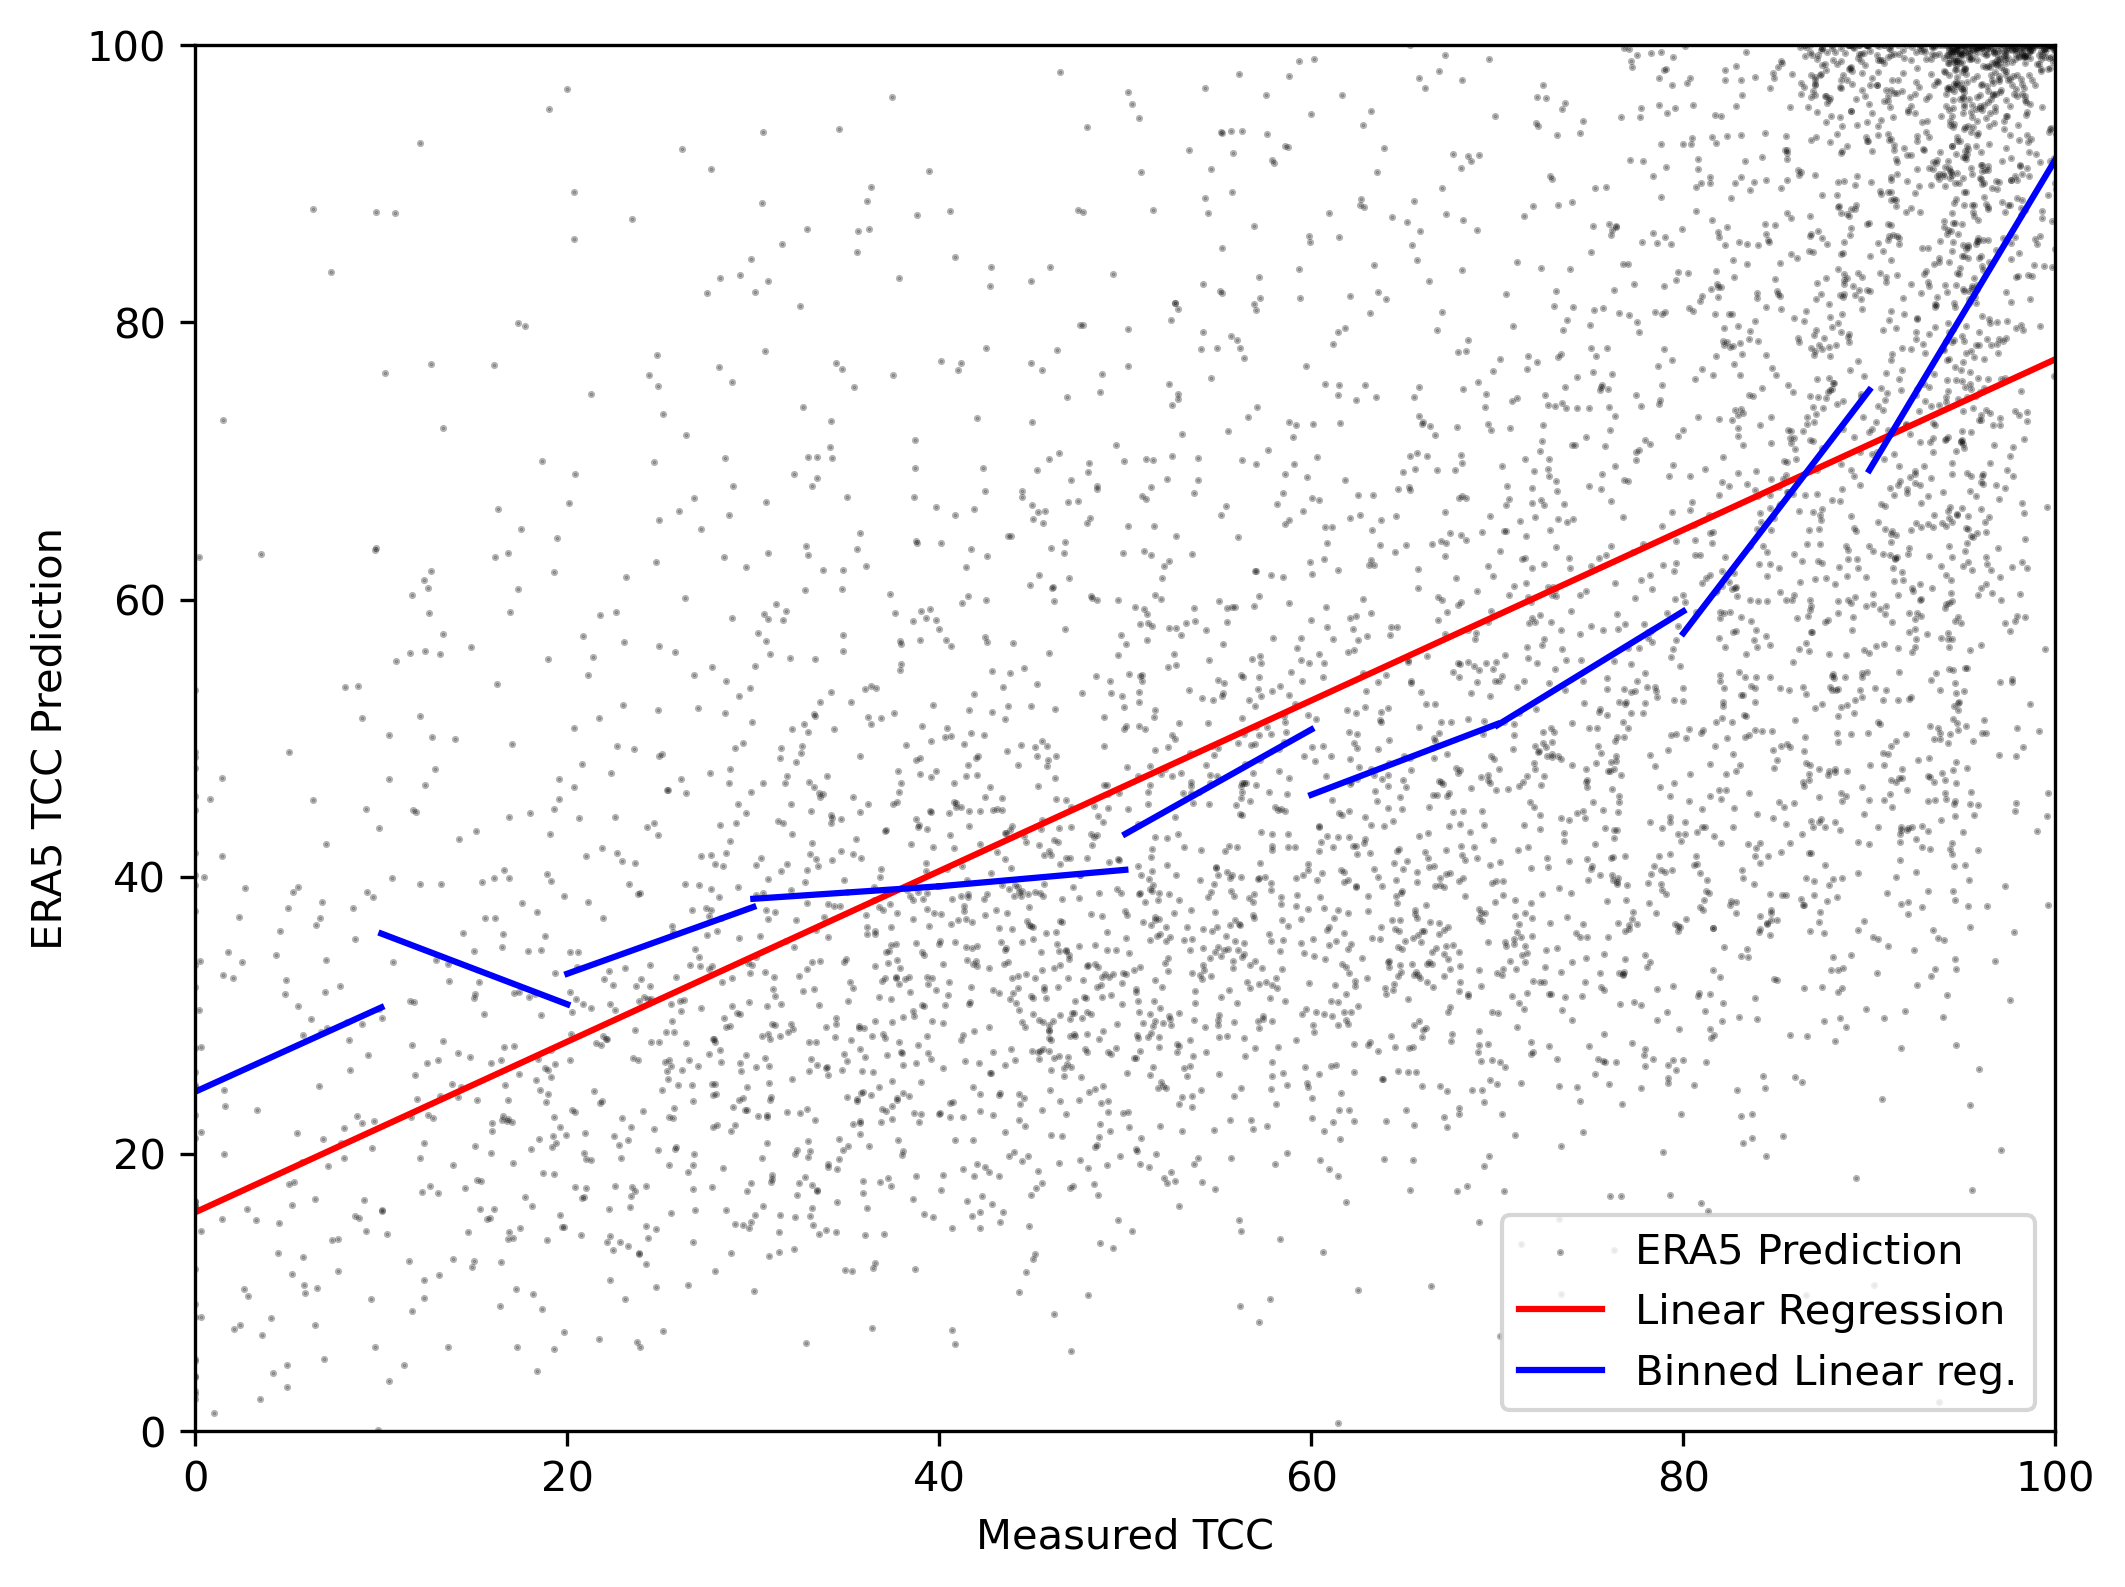

In [11]:
plot_diff_percentage_bined_average(y_true, y_era5, "Measured TCC", "ERA5 TCC Prediction")